#### Load and preprocess stock data from CSV

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks
from datetime import datetime

# Read the CSV file
def load_stock_data(filename):
    # Load your dataset
    df = pd.read_csv(filename)

    # Clean column names (remove extra spaces)
    df.columns = df.columns.str.strip()
    df = df.drop(columns=["Volume"])  # Removes the "Volume" column
    # Convert Date to datetime
    df['Date'] = pd.to_datetime(df['Date'])

    # Clean price columns (remove $ and convert to float)
    price_columns = ['Close/Last', 'Open', 'High', 'Low']
    for col in price_columns:
        df[col] = df[col].str.replace('$', '').astype(float)

    # Sort by date
    df = df.sort_values('Date')
    df = df.reset_index(drop=True)

    return df

df = load_stock_data(filename='./historical data/AAPL_5_yrs.csv')

In [3]:
print(df.head())

        Date  Close/Last     Open     High      Low
0 2020-06-04     80.5800  81.0975  81.4050  80.1950
1 2020-06-05     82.8750  80.8375  82.9375  80.8075
2 2020-06-08     83.3650  82.5625  83.4000  81.8300
3 2020-06-09     85.9975  83.0350  86.4025  83.0025
4 2020-06-10     88.2100  86.9750  88.6925  86.5225


In [4]:
# Calculate ATR (Average True Range) for dynamic threshold
def calculate_atr(df, period=14):
    """Calculate Average True Range for volatility-based thresholds"""
    high = df['High']
    low = df['Low']
    close = df['Close/Last']
    
    # True Range calculation
    tr1 = high - low                # High - Low: The current day's price range.
    tr2 = abs(high - close.shift()) # abs(High - Previous Close): The price gap between today’s high and the previous day’s close.
    tr3 = abs(low - close.shift())  # abs(Low - Previous Close): The price gap between today’s low and the previous day’s close.
    
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    
    # ATR is the rolling mean of TR
    atr = tr.rolling(window=period).mean() # defaut is 14
    
    return atr



#### Detect peak and troughs

In [53]:
def detect_extrema(df, window=49, polyorder=5, distance=15, prominence_factor=0.5, refine_window=2):
    """
    Detect significant peaks and troughs in price data with refinement on raw prices.
    
    Parameters:
    - window: smoothing window size
    - polyorder: polynomial order for Savitzky-Golay filter
    - distance: minimum distance between peaks
    - prominence_factor: factor of ATR used for prominence
    - refine_window: how many bars left/right to search for the exact high/low
    """

    # Step 1: Smooth the signal
    df['Close_Smooth'] = savgol_filter(df['Close/Last'], window, polyorder)

    # Step 2: Compute ATR and set prominence threshold
    df['ATR'] = calculate_atr(df)
    atr_median = df['ATR'].median()
    prominence = atr_median * prominence_factor

    # Step 3: Initial peak detection on smoothed data
    raw_peaks, peak_properties = find_peaks(
        df['Close_Smooth'], distance=distance, prominence=prominence, width=3
    )
    raw_troughs, trough_properties = find_peaks(
        -df['Close_Smooth'], distance=distance, prominence=prominence, width=3
    )

    # Step 4: Refine peak positions by searching in raw prices
    def refine_peak(idx):
        start = max(idx - refine_window, 0)
        end = min(idx + refine_window + 1, len(df))
        return df['Close/Last'].iloc[start:end].idxmax()

    def refine_trough(idx):
        start = max(idx - refine_window, 0)
        end = min(idx + refine_window + 1, len(df))
        return df['Close/Last'].iloc[start:end].idxmin()

    peaks_idx = sorted(set(refine_peak(i) for i in raw_peaks))
    troughs_idx = sorted(set(refine_trough(i) for i in raw_troughs))

    return peaks_idx, troughs_idx, peak_properties, trough_properties


peaks_idx, troughs_idx, peak_properties, trough_properties = detect_extrema(df, window=2, polyorder=1, distance=3, prominence_factor=0.4)

In [54]:
print(len(peaks_idx))

56


#### Trend analysis

##### Find HH, HL, LH, LL

In [59]:
def classify_trend_structure(df, peaks_idx, troughs_idx):
    points = []

    for i in peaks_idx:
        points.append({'index': i, 'price': df['Close/Last'].iloc[i], 'type': 'high'})
    for i in troughs_idx:
        points.append({'index': i, 'price': df['Close/Last'].iloc[i], 'type': 'low'})

    # Sort by index (time order)
    points = sorted(points, key=lambda x: x['index'])

    last_high = None
    last_low = None
    trend = None
    labeled_points = []
    trend_segments = []

    last_trend = None
    last_trend_start = None

    for pt in points:
        idx = pt['index']
        price = pt['price']
        ptype = pt['type']

        if ptype == 'low':
            if last_low is None:
                label = 'L'
            elif price > last_low:
                label = 'HL'
                trend = 'bullish'
            else:
                label = 'LL'
                trend = 'bearish'
            last_low = price

        elif ptype == 'high':
            if last_high is None:
                label = 'H'
            elif trend == 'bullish':
                if price > last_high:
                    label = 'HH'
                else:
                    label = 'H'
            elif trend == 'bearish':
                if price < last_high:
                    label = 'LH'
                else:
                    label = 'H'
            else:
                label = 'H'
            last_high = price

        # If trend changed, record segment
        if trend != last_trend and last_trend is not None and last_trend_start is not None:
            trend_segments.append({
                'start_index': last_trend_start,
                'end_index': idx,
                'trend': last_trend
            })
            last_trend_start = idx
        elif last_trend_start is None and trend is not None:
            last_trend_start = idx

        last_trend = trend

        labeled_points.append({
            'index': idx,
            'price': price,
            'type': ptype,
            'label': label
        })

    # Optionally add the last trend segment
    if last_trend and last_trend_start and len(df) > 0:
        trend_segments.append({
            'start_index': last_trend_start,
            'end_index': len(df) - 1,
            'trend': last_trend
        })

    return pd.DataFrame(labeled_points), trend_segments

structure_df, trend_segments = classify_trend_structure(df, peaks_idx, troughs_idx)


##### Visualization on HH,HL,LH,LL

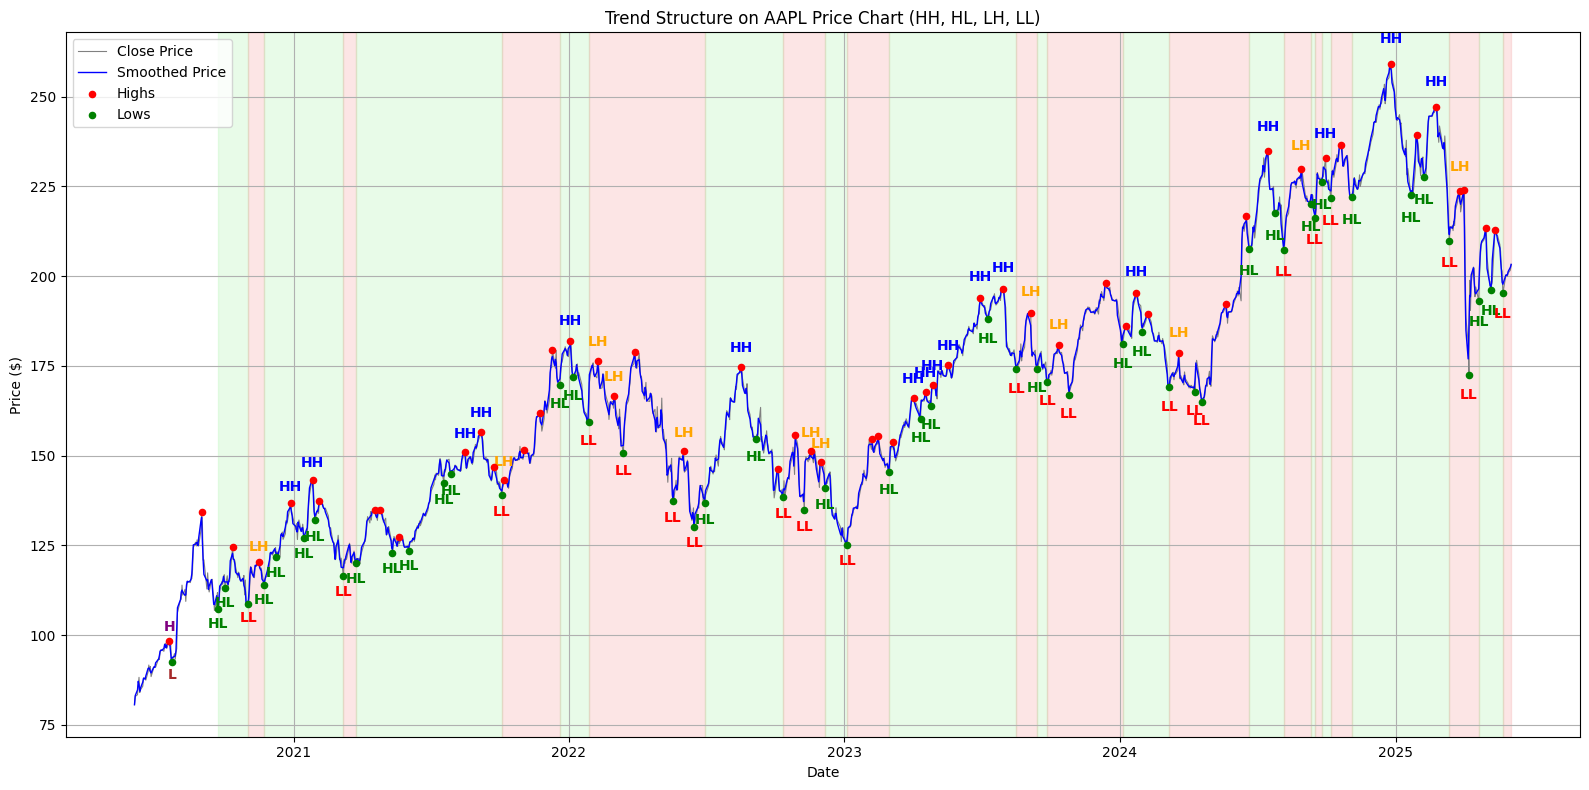

In [60]:
import matplotlib.pyplot as plt

# Label colors
label_colors = {
    'HH': 'blue',
    'HL': 'green',
    'LH': 'orange',
    'LL': 'red',
    'H': 'purple',
    'L': 'brown'
}

plt.figure(figsize=(16, 8))

# Shade bullish/bearish trend regions
for seg in trend_segments:
    start_date = df.loc[seg['start_index'], 'Date']
    end_date = df.loc[seg['end_index'], 'Date']
    color = 'lightgreen' if seg['trend'] == 'bullish' else 'lightcoral'
    plt.axvspan(start_date, end_date, color=color, alpha=0.2)

# Plot lines
plt.plot(df["Date"], df["Close/Last"], label="Close Price", color='gray', linewidth=0.8)
plt.plot(df["Date"], df["Close_Smooth"], label="Smoothed Price", color='blue', linewidth=1)

# Extract highs and lows from structure_df for scatter plotting
high_labels = ['H', 'HH', 'LH']
low_labels = ['L', 'HL', 'LL']

highs_df = structure_df[structure_df['label'].isin(high_labels)]
lows_df = structure_df[structure_df['label'].isin(low_labels)]

# Plot highs and lows as scatter points
plt.scatter(df.loc[highs_df['index'], 'Date'], highs_df['price'], color='red', label="Highs", s=20, zorder=5)
plt.scatter(df.loc[lows_df['index'], 'Date'], lows_df['price'], color='green', label="Lows", s=20, zorder=5)

# Label structure points
h_l_shown = {'H': False, 'L': False}
for _, row in structure_df.iterrows():
    date = df.loc[row['index'], 'Date']
    price = row['price']
    label = row['label']

    # Only show first standalone H/L
    if label in ['H', 'L']:
        if h_l_shown[label]:
            continue
        else:
            h_l_shown[label] = True

    color = label_colors.get(label, 'black')

    if label in low_labels:
        y_offset = -price * 0.02
        va = 'top'
    else:
        y_offset = price * 0.02
        va = 'bottom'

    plt.text(date, price + y_offset, label, color=color, fontsize=10, fontweight='bold',
             ha='center', va=va)

# Final plot touches
plt.title("Trend Structure on AAPL Price Chart (HH, HL, LH, LL)")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
def detect_trends(df_inflex):
    trends = []
    last_high = None
    last_low = None
    current_trend = 'sideways'

    for i in range(1, len(df_inflex)):
        row = df_inflex.iloc[i]
        prev_row = df_inflex.iloc[i - 1]

        if row['point'] == 'high' and prev_row['point'] == 'low':
            if last_high is not None and last_low is not None:
                if row['InflexionPrice'] > last_high and prev_row['InflexionPrice'] > last_low:
                    current_trend = 'bullish'
            last_high = row['InflexionPrice']
            last_low = prev_row['InflexionPrice']

        elif row['point'] == 'low' and prev_row['point'] == 'high':
            if last_high is not None and last_low is not None:
                if row['InflexionPrice'] < last_low and prev_row['InflexionPrice'] < last_high:
                    current_trend = 'bearish'
            last_low = row['InflexionPrice']
            last_high = prev_row['InflexionPrice']

        trends.append({
            'StartDate': prev_row['Date'],
            'EndDate': row['Date'],
            'StartPrice': prev_row['InflexionPrice'],
            'EndPrice': row['InflexionPrice'],
            'Trend': current_trend
        })

    return pd.DataFrame(trends)
trend_segments = detect_trends(df_inflex)

#### Visualization

#### Generate Summary Report

#### Improvements

1. Reduce the Window Size (Most Important)
Smaller window = less smoothing = closer fit to actual data
Instead of window=49, try:
window=21  # Much closer fit
window=15  # Even closer
window=9   # Very close to actual data

2. Increase the Polynomial Order
Higher polynomial = more flexible curve
Instead of polyorder=5, try:
polyorder=7   # More flexible
polyorder=9   # Even more flexible
Note: polyorder must be less than window size

In [ ]:
last_high = None
last_low = None
for i in (len(df_4h)):

    current_price = df_4h["Price"].iloc[i]
    current_point = df_4h["point"].iloc[i]
    current_trend = df_4h["trend"].iloc[i]
    current_bearish_resistant = df_4h["bearish_resistant"].iloc[i]
    current_bearish_support = df_4h["bearish_support"].iloc[i]
    current_bullish_support = df_4h["bullish_support"].iloc[i]

    if last_low is not None and last_high is not None: 
        if pd.isNan(current_trend) and current_price < last_low:
            current_trend = "bearish"
            current_bearish_resistant = last_high
            current_bearish_support = current_price
        elif pd.isNan(current_trend) and current_price > last_high:
            current_trend = "bullish"

    if current_point == "high":
        if last_high == None:
            df_4h['label'].iloc[i] = "H"
            last_high = current_price
        else:
            if current_price > last_high and current_trend == "bearish":
                last_high = current_price
                if current_price <= current_bearish_resistant:
                    df_4h['label'].iloc[i] = "LH"
                elif current_price > current_bearish_resistant:
                    df_4h['label'].iloc[i] = "H"
                    current_trend = "bullish"
                    current_bullish_support = current_bearish_resistant
                    current_bearish_resistant = np.NaN
            elif current_price > last_high and current_trend == "bullish": # only evaluated if the "if" condition is false
                last_high = current_price
                df_4h['label'].iloc[i] = "HH"
                # bullish resistant? 


    elif current_point == "low":
        if last_low == None:
            df_4h['label'].iloc[i] = "L"
            last_low = current_price
        else:                                                           # There is a last low point
            if current_price < last_low and current_trend == "bearish":
                last_low = current_price
                if current_price <= current_bearish_support:
                    df_4h['label'].iloc[i] = "LL"
                    
                last_low = current_price
                


            

            else: 
    

    # update current trend to the next time point
    df_4h["trend"].iloc[i+1] = current_trend
    df_4h["bearish_resistant"].iloc[i+1] = current_bearish_resistant
    df_4h["bullish_support"].iloc[i+1] = current_bullish_support